# Data Science for Business - Multi-Layer Perceptron (MLP) on Wine Reviews with TensorFlow

## Initialize notebook
Load required packages and set up workspace, e.g., initialize the random number generator.

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from sklearn import metrics
import matplotlib.pyplot as plt

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

Check if we are running on GPU.

In [4]:
tf.config.experimental.list_physical_devices('GPU')

[]

# Problem description

The dataset contains 130.000+ wine reviews (Source: https://www.kaggle.com/datasets/zynicide/wine-reviews) written by professional sommeliers. Besides a text, it contains information about the wine, such as the country of origin, the variety, the winery, the price, and the number of points given by the reviewer. The goal is this notebook is to predict the number of points given by the reviewer based on the text of the review.

In [6]:
corpus = pd.read_csv("https://raw.githubusercontent.com/olivermueller/ds4b-2024/refs/heads/main/Session_10/winemag-data-130k-v2.csv")
corpus.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


Split data into three sets: training, validation, and test.

In [15]:
training = corpus.iloc[0:80000,].sample(n=10000) # to speed up training
validation = corpus.iloc[80000:100000,]
test = corpus.iloc[100000:,]

For each dataset, store features and targets in separate variables

In [16]:
train_corpus_features = training[["description"]]
train_corpus_target = training[["points"]]
val_corpus_features = validation[["description"]]
val_corpus_target = validation[["points"]]
test_corpus_features = test[["description"]]
test_corpus_target = test[["points"]]

Next, we have to create [TensorFlow `Datasets`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) from the Pandas dataframes. The use of TensorFlow Datasets follows a common pattern:

1.   Create a dataset from raw data (e.g., a Pandas dataframe, a CSV file, multiple text files).
2.   Apply transformations to preprocess the data in the dataset (e.g., tokenize and vectorize the texts).
3. Iterate over the dataset and process its elements. Iteration happens in a streaming fashion, so the full dataset does not need to fit into memory.

Here, we use the `from_tensor_slices` constructor to create datasets from dataframes.

In [17]:
train_ds = tf.data.Dataset.from_tensor_slices((tf.cast(train_corpus_features.values, tf.string),
                                               tf.cast(train_corpus_target.values, tf.int32)))

val_ds = tf.data.Dataset.from_tensor_slices((tf.cast(val_corpus_features.values, tf.string),
                                             tf.cast(val_corpus_target.values, tf.int32)))

test_ds = tf.data.Dataset.from_tensor_slices((tf.cast(test_corpus_features.values, tf.string),
                                              tf.cast(test_corpus_target.values, tf.int32)))

Display some stats and examples from the created datasets.

In [18]:
for inputs, targets in train_ds:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print("===")
    print("inputs[0]:", inputs[0])
    print("targets[0]:", targets[0])
    break

inputs.shape: (1,)
inputs.dtype: <dtype: 'string'>
targets.shape: (1,)
targets.dtype: <dtype: 'int32'>
===
inputs[0]: tf.Tensor(b"This Cab-based Bordeaux blend is very dense in fruit and also very Tannic with a capital T. Such is the astringency that it may never go away before the blackberry and black currant fruit drops out. Nonetheless it's dry and savory and, in its own Rockpiley way, classic. Drink with superrich barbecue, well-marbled grilled beef and such. Tasted twice.", shape=(), dtype=string)
targets[0]: tf.Tensor(89, shape=(), dtype=int32)


# Vectorize documents

We will now use [TensorFlow's `TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) function to transform raw texts into numerical vectors. To do this, we simply map words to integers (`output_mode = 'int'`). To get document representation of a fixed length, we limit the length of documents to 100 tokens (longer documents will be truncated, shorter documents will be padded with zeros). We also set a maximum vocabulary size of 10000 words.

In [19]:
max_tokens = 10000
max_length = 100

text_vectorization = TextVectorization(
    max_tokens = max_tokens,
    output_mode = "int",
    output_sequence_length = max_length
)

Some apects of the `TextVectorization` function (e.g., the size and contents of the vocabulary) have to be fit using training data, which can be done with the `adapt` function (which can only be applied to the features (x) of the dataset). 

In [20]:
train_ds_features_only = train_ds.map(lambda x, y: x)
text_vectorization.adapt(train_ds_features_only)

2025-01-08 21:08:11.334133: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Show the vocabulary that our vectorizer knows after being fit to the training data.

In [21]:
text_vectorization.get_vocabulary()[0:10]

['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine']

Now, we can apply our adapted `text_vectorization` function to all three datasets.

In [22]:
vectorized_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls = 4)

vectorized_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls = 4)

vectorized_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls = 4)

Show results.

In [23]:
for inputs, targets in vectorized_train_ds:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print("===")
    print("inputs[0]:", inputs[0])
    print("targets[0]:", targets[0])
    break

inputs.shape: (1, 100)
inputs.dtype: <dtype: 'int64'>
targets.shape: (1,)
targets.dtype: <dtype: 'int32'>
===
inputs[0]: tf.Tensor(
[   7 7069  598   52    8   63  144   11   16    2  114   63  104    6
    4 7052 8254  738    8    3  953   20   13  619 1067  557  853  406
    3   53    2   29  137   16 3846   82 1514   14   43    2  141    2
   11   14  643 9072  301  452   25    6 3294  952 7575  367  500    2
  738 1385 3276    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0], shape=(100,), dtype=int64)
targets[0]: tf.Tensor(89, shape=(), dtype=int32)


We can use `get_vocabulary()` to get the word behind a specific index.

In [28]:
text_vectorization.get_vocabulary()[1385]

'tasted'

# Train model

We are now ready to specify a neural network and feed it with the vectroized datasets. For convenience, we define a custome function `get_model` which defines the network architecture, creates a model from it, and compiles this model (by defining, e.g., an otpimizer and loss function). Note that we have to somehow reduce the dimensionality of the output of the embedding layer (sequence_length*embedding_dim). Here, we simply perform a global average pooling (i.e., average each element of the embedding vector over all tokens).

In [29]:
def get_model(hidden_dim=32):
    inputs = keras.Input(shape=(max_length,), dtype="int64")
    embedded = layers.Embedding(input_dim=max_tokens, output_dim=300, mask_zero=True)(inputs)
    hidden1 = layers.GlobalAveragePooling1D()(embedded)
    hidden2 = layers.Dense(hidden_dim, activation = "relu")(hidden1)
    outputs = layers.Dense(1, activation = "linear")(hidden2)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer = tf.optimizers.Adam(),
                  loss = "mean_absolute_error",
                  metrics = ["mean_absolute_error"])
    return model

Instantiate model and show it's architecture.

In [30]:
model = get_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 300)  │  3,000,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 100)       │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 300)       │          0 │ embedding[0][0],  │
│ (GlobalAveragePool… │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      9,632 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         33 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,009,665 (11.48 MB)

 Trainable params: 3,009,665 (11.48 MB)

 Non-trainable params: 0 (0.00 B)

Fit model on training data and save best model to disk. We use the validation set to monitor how the performance of the model evolves during training.

In [31]:
callbacks = [keras.callbacks.ModelCheckpoint("mlp.keras", save_best_only=True)]

history = model.fit(vectorized_train_ds.cache(),
          validation_data = vectorized_val_ds.cache(),
          epochs = 3,
          batch_size = 128,
          callbacks = callbacks)

Epoch 1/3
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 49s 5ms/step - loss: 11.7537 - mean_absolute_error: 11.7537 - val_loss: 4.4900 - val_mean_absolute_error: 4.4900
Epoch 2/3
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 47s 5ms/step - loss: 3.5432 - mean_absolute_error: 3.5432 - val_loss: 3.4240 - val_mean_absolute_error: 3.4240
Epoch 3/3
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 47s 5ms/step - loss: 2.9281 - mean_absolute_error: 2.9281 - val_loss: 3.2967 - val_mean_absolute_error: 3.2967


Plot the learning process.

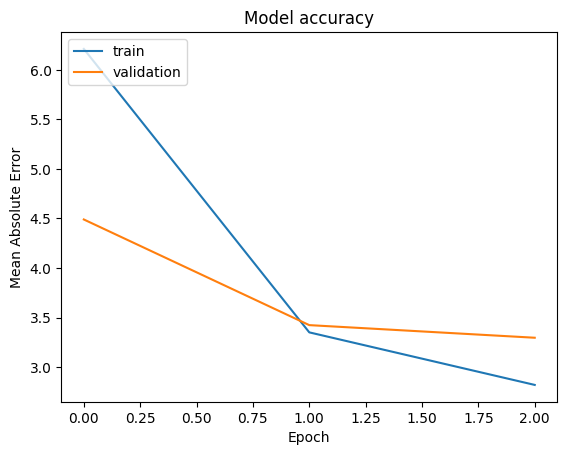

In [32]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('Model accuracy')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Make predictions

Load best model from training phase.

In [33]:
model = keras.models.load_model("mlp.keras")

Make predictions on test set.

In [34]:
preds = model.predict(vectorized_test_ds)

29971/29971 ━━━━━━━━━━━━━━━━━━━━ 9s 299us/step


Calculate prediction error.

In [35]:
print(metrics.mean_absolute_error(test_corpus_target, preds))

3.3219871769191336
